# Dataset Preperation

In [ ]:
!pip install albumentations

In [ ]:
import albumentations as A
import cv2
import numpy as np
import os
from glob import glob
import random
import shutil

# Define augmentation pipeline
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.7),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussianBlur(p=0.2)
])

# Load images from folder
image_paths = glob("/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites/*.png")
save_folder = "/content/drive/MyDrive/Colab Notebooks/Model/augmented_images"
os.makedirs(save_folder, exist_ok=True)

# Augment and save images
for img_path in image_paths:
    img = cv2.imread(img_path)

    if img is None:
        print(f"Warning: Could not read image {img_path}")
        continue

    for i in range(10):
        augmented = augmentations(image=img)['image']
        filename = os.path.join(save_folder, f"{os.path.basename(img_path).split('.')[0]}_aug_{i}.png")

        print(f"Saving: {filename}")  # Debugging: Check if filenames are generated
        cv2.imwrite(filename, augmented)

print("Augmentation completed!")

drive_png_folder = "/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites"

# Ensure the augmented images directory exists
os.makedirs(save_folder, exist_ok=True)

# Get all PNG images in the drive folder
png_images = [f for f in os.listdir(drive_png_folder) if f.endswith('.png')]

# Copy PNG images to augmented images folder
for img_name in png_images:
    src_path = os.path.join(drive_png_folder, img_name)
    dst_path = os.path.join(save_folder, img_name)
    shutil.copy(src_path, dst_path)

print(f"Added {len(png_images)} PNG images to the augmented folder.")


Saving: /content/drive/MyDrive/Colab Notebooks/Model/augmented_images/siteImage_aug_0.png
Saving: /content/drive/MyDrive/Colab Notebooks/Model/augmented_images/siteImage_aug_1.png
Saving: /content/drive/MyDrive/Colab Notebooks/Model/augmented_images/siteImage_aug_2.png
Saving: /content/drive/MyDrive/Colab Notebooks/Model/augmented_images/siteImage_aug_3.png
Saving: /content/drive/MyDrive/Colab Notebooks/Model/augmented_images/siteImage_aug_4.png
Saving: /content/drive/MyDrive/Colab Notebooks/Model/augmented_images/siteImage_aug_5.png
Saving: /content/drive/MyDrive/Colab Notebooks/Model/augmented_images/siteImage_aug_6.png
Saving: /content/drive/MyDrive/Colab Notebooks/Model/augmented_images/siteImage_aug_7.png
Saving: /content/drive/MyDrive/Colab Notebooks/Model/augmented_images/siteImage_aug_8.png
Saving: /content/drive/MyDrive/Colab Notebooks/Model/augmented_images/siteImage_aug_9.png
Saving: /content/drive/MyDrive/Colab Notebooks/Model/augmented_images/siteImage1_aug_0.png
Saving: /

In [ ]:
import json


json_file_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites/labels_my-project-name_2025-03-07-10-07-36.json"

# Load COCO JSON file
with open(json_file_path, "r") as f:
    coco_data = json.load(f)

# Define augmentation
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.7)
], bbox_params=A.BboxParams(format='coco', label_fields=['category_id']))

# Create output folder for augmented images
os.makedirs("augmented_images", exist_ok=True)

new_images = []
new_annotations = []
new_image_id = max(img["id"] for img in coco_data["images"]) + 1
new_annotation_id = max(ann["id"] for ann in coco_data["annotations"]) + 1

# Process each image
for img_info in coco_data["images"]:
    img_path = os.path.join("/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites", img_info["file_name"])
    img = cv2.imread(img_path)

    if img is None:
        print(f"Skipping {img_info['file_name']} (not found)")
        continue

    # Get annotations for this image
    ann_ids = [ann for ann in coco_data["annotations"] if ann["image_id"] == img_info["id"]]
    bboxes = [ann["bbox"] for ann in ann_ids]
    category_ids = [ann["category_id"] for ann in ann_ids]

    for i in range(10):  # Generate 10 augmented images per original
        # Apply augmentation
        augmented = augmentations(image=img, bboxes=bboxes, category_id=category_ids)

        # Save augmented image
        new_filename = img_info["file_name"].replace(".jpg", f"_aug_{i}.jpg").replace(".png", f"_aug_{i}.png")
        cv2.imwrite(os.path.join("augmented_images", new_filename), augmented["image"])

        # Add new image entry to COCO JSON
        new_img_info = img_info.copy()
        new_img_info["file_name"] = new_filename
        new_img_info["id"] = new_image_id
        new_images.append(new_img_info)

        # Add new annotations
        for j, ann in enumerate(ann_ids):
            new_ann = ann.copy()
            new_ann["id"] = new_annotation_id
            new_ann["bbox"] = augmented["bboxes"][j]
            new_ann["image_id"] = new_image_id
            new_annotations.append(new_ann)
            new_annotation_id += 1  # Increment annotation ID

        new_image_id += 1  # Increment image ID

# Update COCO JSON
coco_data["images"].extend(new_images)
coco_data["annotations"].extend(new_annotations)

# Save new COCO JSON
with open("/content/drive/MyDrive/Colab Notebooks/Model/augmented_labels.json", "w") as f:
    json.dump(coco_data, f)

print("COCO annotations updated with augmented images!")


COCO annotations updated with augmented images!


**Testing if the annotations and images map correctly**

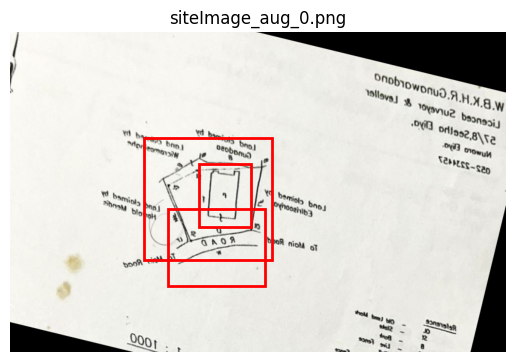

In [ ]:
import matplotlib.pyplot as plt

# Load augmented COCO JSON file
with open('/content/drive/MyDrive/Colab Notebooks/Dataset/Dataset-Sites/augmented_labels.json', 'r') as f:
    coco_data = json.load(f)

# Pick one augmented image
aug_image_info = next((img for img in coco_data["images"] if "_aug_" in img["file_name"]), None)
if aug_image_info is not None:
    img_path = f"/content/augmented_images/{aug_image_info['file_name']}"
    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        annotations = [ann for ann in coco_data["annotations"] if ann["image_id"] == aug_image_info["id"]]

        plt.imshow(img)
        ax = plt.gca()
        for ann in annotations:
            x, y, w, h = ann["bbox"]
            ax.add_patch(plt.Rectangle((x, y), w, h, fill=False, color='red', linewidth=2))
        plt.title(aug_image_info['file_name'])
        plt.axis("off")
        plt.show()
    else:
        print(f"Augmented image not found at: {img_path}")
else:
    print("No augmented image entry found in JSON.")


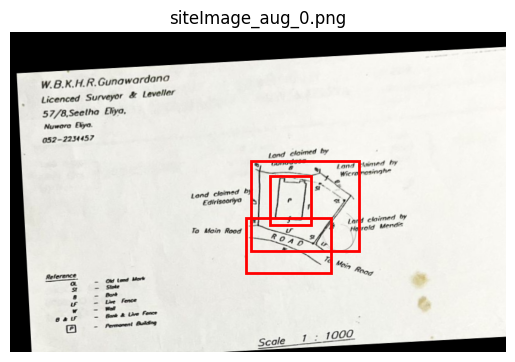

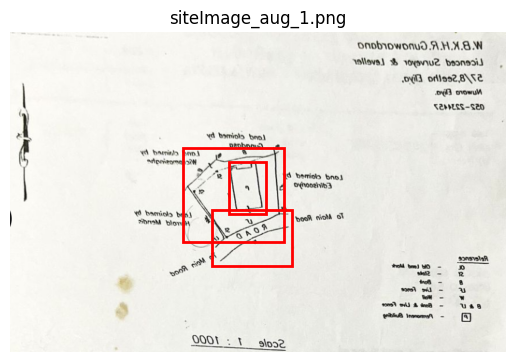

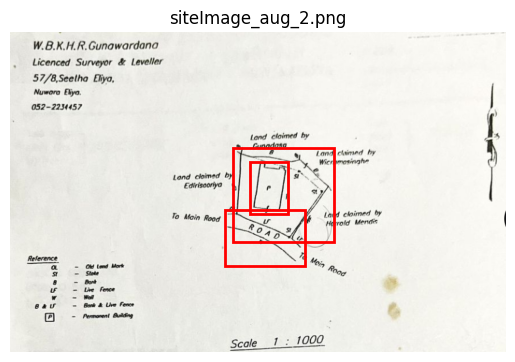

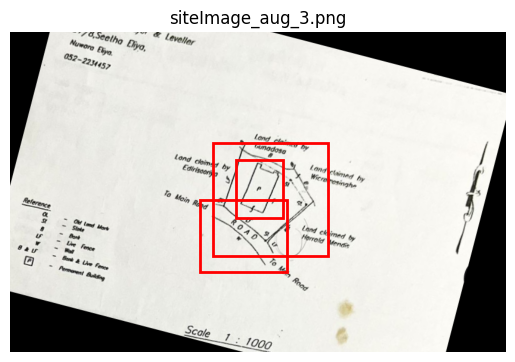

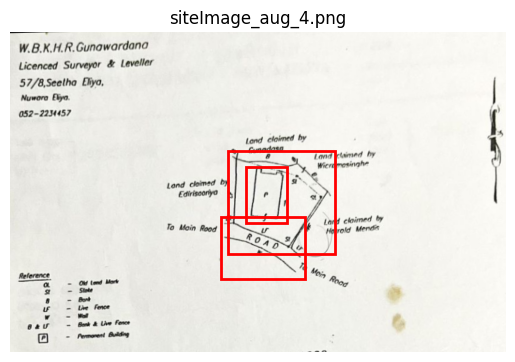

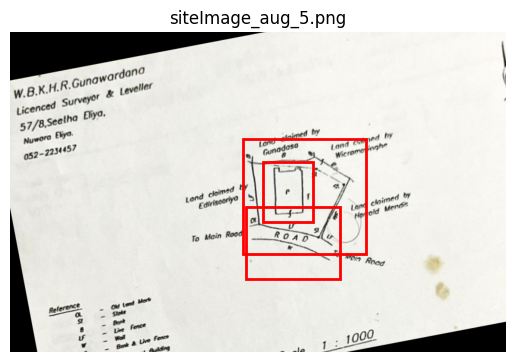

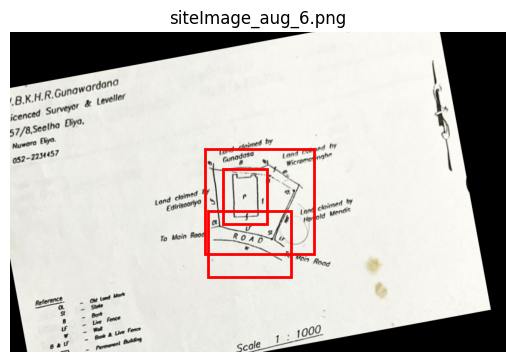

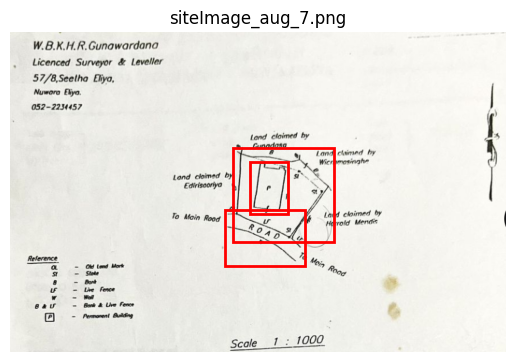

KeyboardInterrupt: 

In [ ]:
# Load augmented COCO JSON file
with open('/content//augmented_labels.json', 'r') as f:
    coco_data = json.load(f)

# Loop through the augmented images in the JSON and display them
for aug_image_info in coco_data["images"]:
    if "_aug_" in aug_image_info["file_name"]:  # Only show augmented images
        img_path = f"/content/augmented_images/{aug_image_info['file_name']}"

        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct display

            annotations = [ann for ann in coco_data["annotations"] if ann["image_id"] == aug_image_info["id"]]

            # Plot image with bounding boxes
            plt.imshow(img)
            ax = plt.gca()
            for ann in annotations:
                x, y, w, h = ann["bbox"]
                ax.add_patch(plt.Rectangle((x, y), w, h, fill=False, color='red', linewidth=2))

            plt.title(aug_image_info['file_name'])
            plt.axis("off")
            plt.show()
        else:
            print(f"Augmented image not found at: {img_path}")

In [ ]:
!pip install opencv-python


# **Training The Model**

In [ ]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Check if GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Load a pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Have 3 object classes plus background
num_classes = 1 + 3  # 1 background + 3 classes

# Get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the pre-trained head with a new one (that has num_classes outputs)
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Move the model to the appropriate device
model.to(device)

print("Faster R-CNN model is set up and ready for training/fine-tuning!")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Faster R-CNN model is set up and ready for training/fine-tuning!


Total annotations: 132, Valid annotations after filtering: 90
Image ID remapping: {11: 1, 24: 2, 9: 3, 26: 4, 22: 5, 21: 6, 8: 7, 13: 8, 12: 9, 19: 10, 33: 11, 7: 12, 1: 13, 17: 14, 2: 15, 29: 16, 25: 17, 10: 18, 5: 19, 16: 20, 27: 21, 20: 22, 31: 23}
Total annotations: 132, Valid annotations after filtering: 21
Image ID remapping: {32: 1, 4: 2, 23: 3, 30: 4, 18: 5}
Total annotations: 132, Valid annotations after filtering: 21
Image ID remapping: {3: 1, 14: 2, 28: 3, 6: 4, 15: 5}
Splits created: Train images: 23, Val images: 5, Test images: 5
Images have been copied to their respective directories.


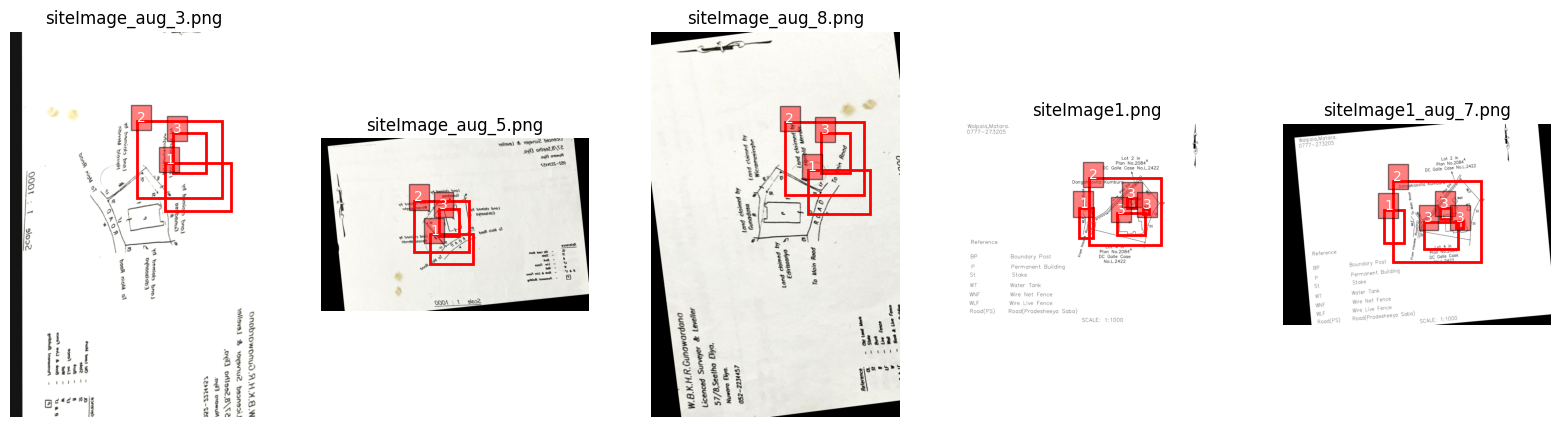

In [ ]:
import random
import matplotlib.patches as patches
-
original_json_path = '/content/drive/MyDrive/Colab Notebooks/Model/augmented_labels.json'
original_images_dir = '/content/drive/MyDrive/Colab Notebooks/Model/augmented_images'

# Output directories for splits
train_images_dir = '/content/drive/MyDrive/Colab Notebooks/Model/train_images'
val_images_dir   = '/content/drive/MyDrive/Colab Notebooks/Model/val_images'
test_images_dir  = '/content/drive/MyDrive/Colab Notebooks/Model/test_images'

# Create directories if they don't exist
for d in [train_images_dir, val_images_dir, test_images_dir]:
    os.makedirs(d, exist_ok=True)


# Load Original JSON and Split Images

with open(original_json_path, 'r') as f:
    coco_data = json.load(f)

# Get list of all images
all_images = coco_data["images"]
total = len(all_images)


random.shuffle(all_images)

# Calculate split indices (70% train, 15% val, 15% test)
train_end = int(0.7 * total)
val_end   = int(0.85 * total)

train_images = all_images[:train_end]
val_images   = all_images[train_end:val_end]
test_images  = all_images[val_end:]

def filter_and_remap_split(original_data, split_images):
    # Get valid image IDs for this split
    valid_ids = {img["id"] for img in split_images}

    # Filter annotations that correspond to these images
    filtered_annotations = [ann for ann in original_data["annotations"] if ann["image_id"] in valid_ids]

    # Debugging: Print to ensure we're filtering correctly
    print(f"Total annotations: {len(original_data['annotations'])}, Valid annotations after filtering: {len(filtered_annotations)}")

    # Remap image IDs to sequential numbers (starting at 1)
    old_to_new = {}
    new_images = []
    for new_id, img in enumerate(split_images, start=1):
        old_to_new[img["id"]] = new_id
        new_img = img.copy()
        new_img["id"] = new_id
        new_images.append(new_img)

    # Debugging: Ensure old_to_new mapping is correct
    print(f"Image ID remapping: {old_to_new}")

    # Update annotations to point to the new image IDs
    new_annotations = []
    for ann in filtered_annotations:
        if ann["image_id"] in old_to_new:
            new_ann = ann.copy()
            new_ann["image_id"] = old_to_new[ann["image_id"]]  # Remap to new image ID
            new_annotations.append(new_ann)
        else:
            print(f"Annotation missing for image ID: {ann['image_id']}")  # Debugging missing annotations

    # Create a new JSON dict for this split.
    new_data = {
        "images": new_images,
        "annotations": new_annotations
    }

    # Include categories if available.
    if "categories" in original_data:
        new_data["categories"] = original_data["categories"]

    return new_data

train_data = filter_and_remap_split(coco_data, train_images)
val_data   = filter_and_remap_split(coco_data, val_images)
test_data  = filter_and_remap_split(coco_data, test_images)

# Save Fixed JSON Files for Each Split
train_json_path = '/content/drive/MyDrive/Colab Notebooks/Model/augmented_labels_train.json'
val_json_path   = '/content/drive/MyDrive/Colab Notebooks/Model/augmented_labels_val.json'
test_json_path  = '/content/drive/MyDrive/Colab Notebooks/Model/augmented_labels_test.json'

with open(train_json_path, 'w') as f:
    json.dump(train_data, f)
with open(val_json_path, 'w') as f:
    json.dump(val_data, f)
with open(test_json_path, 'w') as f:
    json.dump(test_data, f)

print(f"Splits created: Train images: {len(train_data['images'])}, Val images: {len(val_data['images'])}, Test images: {len(test_data['images'])}")

def copy_images(image_list, src_dir, dst_dir):
    for img in image_list:
        src_path = os.path.join(src_dir, img["file_name"])
        dst_path = os.path.join(dst_dir, img["file_name"])
        if os.path.exists(src_path):
            shutil.copy(src_path, dst_path)
        else:
            print(f"Image not found: {src_path}")

copy_images(train_images, original_images_dir, train_images_dir)
copy_images(val_images, original_images_dir, val_images_dir)
copy_images(test_images, original_images_dir, test_images_dir)

print("Images have been copied to their respective directories.")


def visualize_images(data, image_dir, num_images=5):
    category_map = {cat["id"]: cat["name"] for cat in data["categories"]}
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))

    if num_images == 1:
        axes = [axes]  # Ensure iterable if only one image

    sampled_images = random.sample(data["images"], num_images)

    for ax, img_info in zip(axes, sampled_images):
        img_path = os.path.join(image_dir, img_info["file_name"])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ax.imshow(image)
        ax.set_title(img_info["file_name"])
        ax.axis("off")

        # Plot bounding boxes
        for ann in data["annotations"]:
            if ann["image_id"] == img_info["id"]:
                bbox = ann["bbox"]
                x, y, w, h = bbox  # COCO format: [x, y, width, height]
                rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                label = category_map.get(ann["category_id"], "Unknown")
                ax.text(x, y, label, color='white', fontsize=10, bbox=dict(facecolor='red', alpha=0.5))

    plt.show()

# Run visualizations
visualize_images(train_data, train_images_dir, num_images=5)


In [ ]:
from torch.utils.data import DataLoader
from torchvision import models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm


train_dataset = CustomDataset(img_folder='/content/train_images', ann_file='/content/augmented_labels_train.json', transform=None)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Use a pre-trained Faster R-CNN model from torchvision
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.to(device)

num_classes = 4  # COCO dataset has 3 classes + 1 background class
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Define optimizer and learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop
num_epochs = 5
model.train()

for epoch in range(num_epochs):
    total_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for images, targets in progress_bar:
        # Move images and targets to device
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        loss_dict = model(images, targets)

        # Total loss
        losses = sum(loss for loss in loss_dict.values())
        total_loss += losses.item()

        # Backward pass
        losses.backward()

        # Update the weights
        optimizer.step()

        progress_bar.set_postfix(loss=losses.item())

    # Step the learning rate scheduler
    lr_scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Total Loss: {total_loss:.4f}")

# Save the trained model
torch.save(model.state_dict(), 'fasterrcnn.pth')

print("Training complete. Model saved to 'fasterrcnn.pth'.")


Epoch 1/5: 100%|██████████| 12/12 [09:31<00:00, 47.60s/it, loss=1.58]


Epoch 1/5, Total Loss: 22.5432


Epoch 2/5: 100%|██████████| 12/12 [09:21<00:00, 46.79s/it, loss=0.727]


Epoch 2/5, Total Loss: 10.1580


Epoch 3/5: 100%|██████████| 12/12 [09:25<00:00, 47.08s/it, loss=0.558]


Epoch 3/5, Total Loss: 6.2062


Epoch 4/5: 100%|██████████| 12/12 [09:21<00:00, 46.75s/it, loss=0.541]


Epoch 4/5, Total Loss: 4.8964


Epoch 5/5: 100%|██████████| 12/12 [09:23<00:00, 46.98s/it, loss=0.335]


Epoch 5/5, Total Loss: 3.7469
Training complete. Model saved to 'fasterrcnn.pth'.


In [ ]:
from torchvision import models

# Initialize the model architecture
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
num_classes = 4
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Load the model's weights from the file
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Model/fasterrcnn.pth'))

# Move the model to the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set the model to evaluation mode
model.eval()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 101MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [ ]:
from PIL import Image
import torchvision.transforms as T

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_model(model_path):
    """Load the Faster R-CNN model with custom weights."""
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    num_classes = 4
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    return model

def predict_and_visualize(model, image_path, threshold=0.5):
    """Run inference on an image and visualize predictions."""
    # Load and convert image to RGB
    image = Image.open(image_path).convert("RGB")  # Ensures 3-channel format

    # Transform the image
    transform = T.Compose([T.ToTensor()])
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Run inference
    with torch.no_grad():
        prediction = model(image_tensor)

    # Extract boxes, labels, and scores
    boxes = prediction[0]['boxes'].cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().numpy()

    # Define label colors
    label_colors = {
        1: 'red',
        2: 'blue',
        3: 'green'
    }

    # Plot image with bounding boxes
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(np.array(image))

    for i in range(len(boxes)):
        if scores[i] > threshold:
            box = boxes[i]
            label = labels[i]
            color = label_colors.get(label, 'yellow')

            rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                 linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
            ax.text(box[0], box[1], f'{label}: {scores[i]:.2f}', color=color, fontsize=12)

    plt.show()


# Load the model once
model_path = '/content/drive/MyDrive/Colab Notebooks/Model/fasterrcnn.pth'
model = load_model(model_path)

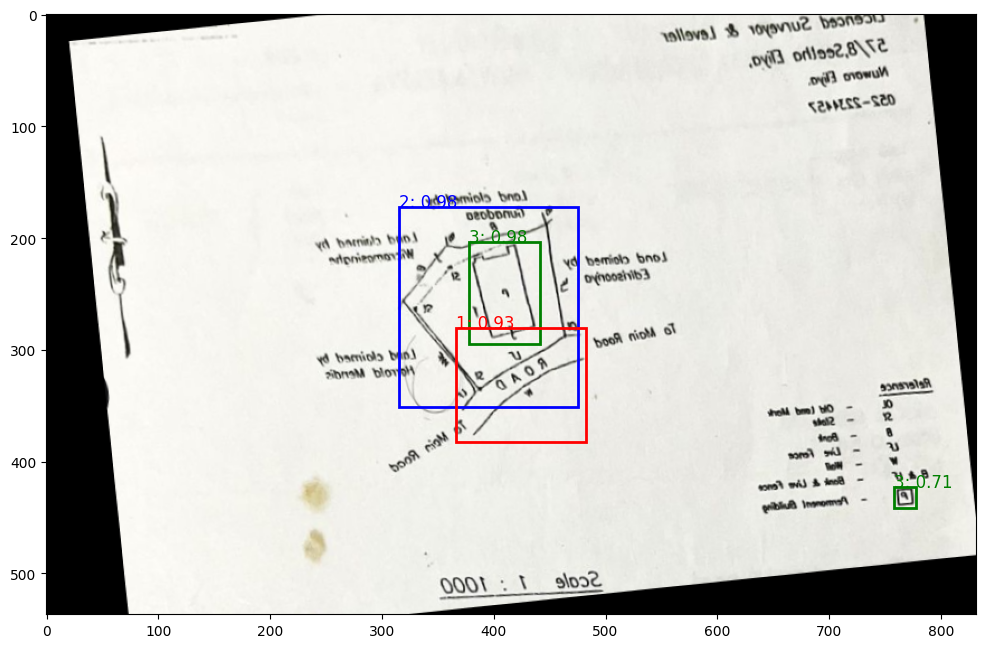

In [ ]:

# Test on a new image
image_path = '/content/drive/MyDrive/Colab Notebooks/Model/train_images/siteImage_aug_5.png'
predict_and_visualize(model, image_path)


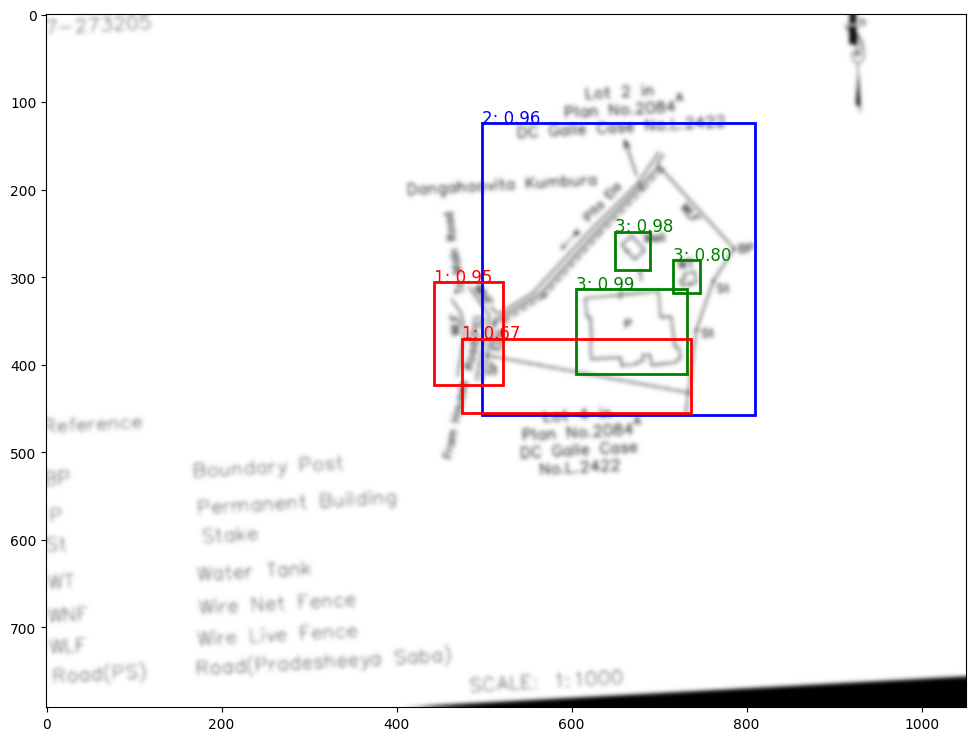

In [ ]:

# Test on a new image
image_path = '/content/drive/MyDrive/Colab Notebooks/Model/train_images/siteImage1_aug_3.png'
predict_and_visualize(model, image_path)


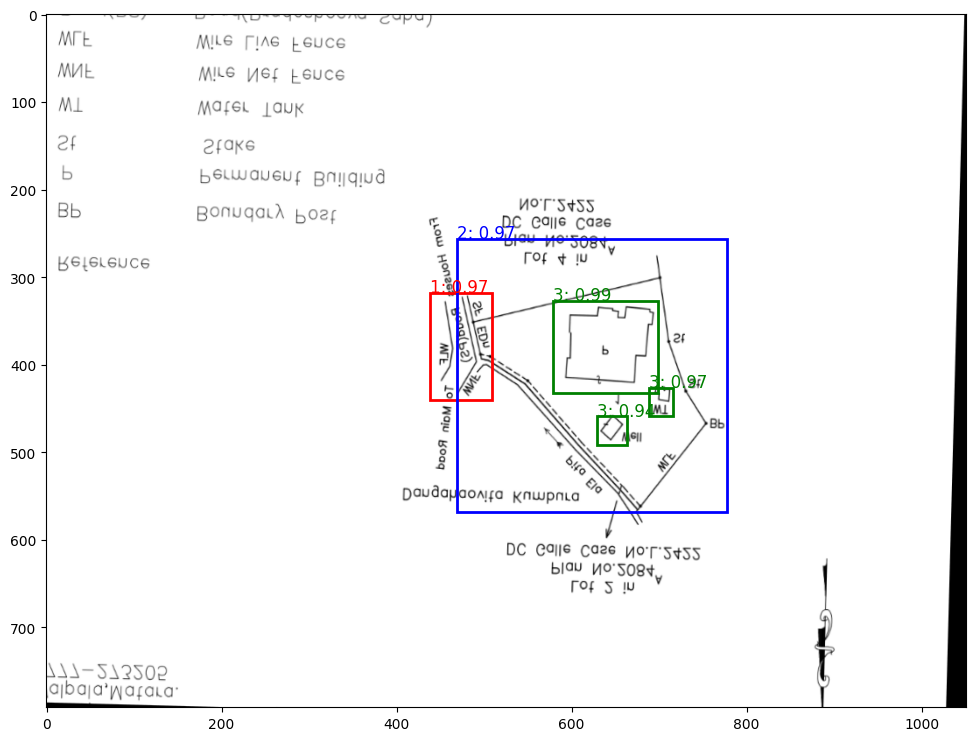

In [ ]:
image_path = '/content/drive/MyDrive/Colab Notebooks/Model/train_images/siteImage1_aug_6.png'
predict_and_visualize(model, image_path)

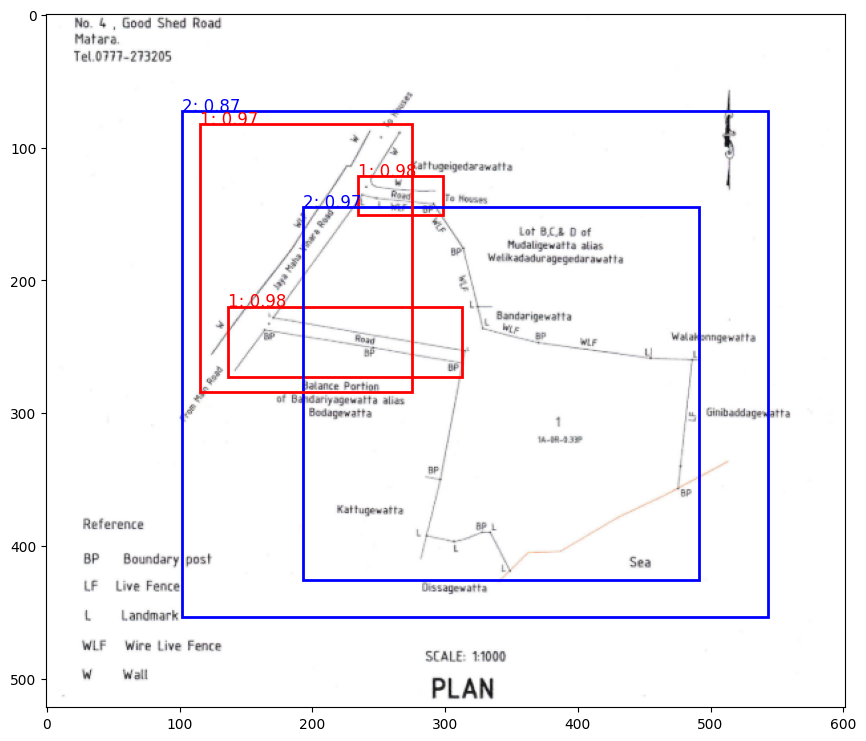

In [ ]:
image_path = '/content/drive/MyDrive/Colab Notebooks/Model/test_images/siteImage2.png'
predict_and_visualize(model, image_path)

In [ ]:
!pip install torchmetrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.6/931.6 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 819.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [ ]:
from PIL import Image
import torchvision.transforms as T
from pycocotools.coco import COCO  # Import COCO for ID mapping

# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Faster R-CNN model architecture
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=False)  # Load an untrained model
model_path = '/content/drive/MyDrive/Colab Notebooks/Model/fasterrcnn.pth'

# Load the trained weights
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()  # Set to evaluation mode

# Paths
test_image_dir = '/content/drive/MyDrive/Colab Notebooks/Model/test_images'
ground_truth_path = '/content/drive/MyDrive/Colab Notebooks/Model/augmented_labels_test.json'
output_predictions_file = '/content/drive/MyDrive/Colab Notebooks/Model/predictions.json'

# Load ground truth dataset to map filenames to numerical image IDs
coco_gt = COCO(ground_truth_path)
image_id_mapping = {img["file_name"]: img["id"] for img in coco_gt.dataset["images"]}

# Get list of image paths
test_image_paths = [
    os.path.join(test_image_dir, f) for f in os.listdir(test_image_dir)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

# Define image transformation
transform = T.Compose([T.ToTensor()])

# Minimum confidence threshold for filtering predictions
CONFIDENCE_THRESHOLD = 0.5

# List to store predictions in COCO format
predictions = []

# Loop through test images
for img_path in test_image_paths:
    try:
        # Extract filename and check if it exists in ground truth
        image_filename = os.path.basename(img_path)
        if image_filename not in image_id_mapping:
            print(f"Warning: {image_filename} is missing in ground truth.")
            continue  # Skip images not in ground truth

        image_id = image_id_mapping[image_filename]  # Get numerical image ID

        # Load and preprocess the image
        image = Image.open(img_path).convert("RGB")
        image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension & move to device

        # Run the model
        with torch.no_grad():
            prediction = model(image_tensor)

        # Extract prediction data
        boxes = prediction[0]['boxes'].cpu().numpy()  # Bounding box coordinates
        scores = prediction[0]['scores'].cpu().numpy()  # Confidence scores
        labels = prediction[0]['labels'].cpu().numpy()  # Class labels

        # Convert from [x1, y1, x2, y2] to [x, y, width, height]
        boxes[:, 2] -= boxes[:, 0]  # width = x2 - x1
        boxes[:, 3] -= boxes[:, 1]  # height = y2 - y1

        # Filter predictions based on confidence threshold
        valid_indices = scores >= CONFIDENCE_THRESHOLD
        filtered_boxes = boxes[valid_indices].tolist()
        filtered_scores = scores[valid_indices].tolist()
        filtered_labels = labels[valid_indices].tolist()

        # Save predictions in COCO format
        for i in range(len(filtered_boxes)):
            predictions.append({
                "image_id": image_id,  # Use mapped numerical ID
                "category_id": int(filtered_labels[i]),  # Ensure it's an integer
                "bbox": filtered_boxes[i],  # In [x, y, width, height] format
                "score": filtered_scores[i]
            })

    except Exception as e:
        print(f"Error processing {img_path}: {e}")

# Save predictions to JSON
with open(output_predictions_file, 'w') as f:
    json.dump(predictions, f, indent=4)

print(f"Predictions saved to {output_predictions_file}")


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Predictions saved to /content/drive/MyDrive/Colab Notebooks/Model/predictions.json


In [ ]:
!pip install torchmetrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
import torchmetrics.detection as detection_metrics

# Paths to ground truth and predictions
ground_truth_path = '/content/drive/MyDrive/Colab Notebooks/Model/augmented_labels_test.json'
predictions_path = '/content/drive/MyDrive/Colab Notebooks/Model/predictions.json'

# Convert Ground Truth Data
with open(ground_truth_path, 'r') as f:
    ground_truth_data = json.load(f)

# Build ground truth in expected format:
# Each element in 'target' is a dict with keys: image_id, boxes (tensor Nx4), labels (tensor N)
target = []
for image_info in ground_truth_data['images']:
    image_id = image_info['id']
    # Get all annotations for this image
    annotations = [ann for ann in ground_truth_data['annotations'] if ann['image_id'] == image_id]

    boxes, labels = [], []
    for ann in annotations:
        x, y, w, h = ann['bbox']
        # Convert COCO bbox [x, y, w, h] to [x1, y1, x2, y2]
        boxes.append([x, y, x + w, y + h])
        labels.append(ann['category_id'])

    if boxes:  # Only add if there are annotations
        target.append({
            "image_id": image_id,
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64),
        })

with open(predictions_path, 'r') as f:
    preds_data = json.load(f)

# predictions file has keys: "image_id", "bbox", "score", "category_id"
# Torchmetrics expects, for each image: "boxes", "scores", "labels" (grouped by image)
# So group predictions by image_id
preds_grouped = {}
for pred in preds_data:
    image_id = pred["image_id"]
    # Check that required keys exist
    if "bbox" not in pred or "score" not in pred or "category_id" not in pred:
        print(f"Warning: Skipping prediction for image {image_id} due to missing fields.")
        continue
    if image_id not in preds_grouped:
        preds_grouped[image_id] = {"boxes": [], "scores": [], "labels": []}
    preds_grouped[image_id]["boxes"].append(pred["bbox"])
    preds_grouped[image_id]["scores"].append(pred["score"])
    preds_grouped[image_id]["labels"].append(pred["category_id"])

# Now convert grouped predictions into a list of dicts in the expected format
preds = []
for image_id, data in preds_grouped.items():
    boxes = torch.tensor(data["boxes"], dtype=torch.float32)  # shape (N, 4)
    scores = torch.tensor(data["scores"], dtype=torch.float32)  # shape (N,)
    labels = torch.tensor(data["labels"], dtype=torch.int64)      # shape (N,)
    preds.append({
        "image_id": image_id,
        "boxes": boxes,
        "scores": scores,
        "labels": labels,
    })


# Ensure Matching Image IDs

target_image_ids = {item["image_id"] for item in target}
pred_image_ids = {item["image_id"] for item in preds}
common_ids = target_image_ids & pred_image_ids

print(f"Common image IDs: {common_ids}")

# Filter out entries that do not have common image IDs
target = [item for item in target if item["image_id"] in common_ids]
preds = [item for item in preds if item["image_id"] in common_ids]


# Compute mAP with Torchmetrics

metric = detection_metrics.MeanAveragePrecision(iou_thresholds=[0.5, 0.75])
metric.update(preds, target)
result = metric.compute()

# Print results
print("mAP results:")
for key, value in result.items():
    # Convert scalar tensors to Python numbers for printing
    value = value.item() if isinstance(value, torch.Tensor) and value.numel() == 1 else value.tolist()
    print(f"{key}: {value}")


Common image IDs: {1, 2, 3, 4, 5}
mAP results:
map: 0.005775577388703823
map_50: 0.011551154777407646
map_75: 0.0
map_small: 0.0
map_medium: 0.0
map_large: 0.011551154777407646
mar_1: 0.0
mar_10: 0.03333333507180214
mar_100: 0.03333333507180214
mar_small: 0.0
mar_medium: 0.0
mar_large: 0.03333333507180214
map_per_class: -1.0
mar_100_per_class: -1.0
classes: [1, 2, 3]


In [ ]:
!pip install pycocotools

In [ ]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# Paths to your ground truth and predictions files
ground_truth_path = '/content/drive/MyDrive/Colab Notebooks/Model/augmented_labels_test.json'
predictions_path = '/content/drive/MyDrive/Colab Notebooks/Model/predictions.json'

# Load ground truth annotations
coco_gt = COCO(ground_truth_path)

# Load predictions
with open(predictions_path, 'r') as f:
    preds = json.load(f)

# Inspect the image_ids in both ground truth and predictions
ground_truth_image_ids = set(coco_gt.getImgIds())
prediction_image_ids = set([pred['image_id'] for pred in preds])

print(f"Ground truth image IDs: {ground_truth_image_ids}")
print(f"Prediction image IDs: {prediction_image_ids}")

# If there are any discrepancies between image_ids, filter predictions to include only the matching ones
filtered_preds = [pred for pred in preds if pred['image_id'] in ground_truth_image_ids]

# Check if predictions are filtered correctly
print(f"Filtered {len(filtered_preds)} predictions out of {len(preds)}")

# If filtered_preds is empty, print more information
if len(filtered_preds) == 0:
    print("No predictions match ground truth image_ids. Double-check your prediction file.")
else:
    # Add filtered predictions to COCO format
    coco_dt = coco_gt.loadRes(filtered_preds)

    # Create a COCOeval object
    coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')

    # Run the evaluation
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Ground truth image IDs: {1, 2, 3, 4, 5}
Prediction image IDs: {1, 2, 3, 4, 5}
Filtered 39 predictions out of 39
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.100
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.220
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.053
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.065
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.181
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.101
 Average Recall     (AR) @[ IoU=0

In [ ]:
from torch.utils.data import DataLoader, Dataset
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR
from torchvision.datasets import CocoDetection

# Custom collate function to keep targets as a list of dictionaries
def collate_fn(batch):
    return tuple(zip(*batch))

# Define a custom dataset class to load your data and format targets correctly
class CustomDataset(Dataset):
    def __init__(self, root, ann_file, transforms=None):
        self.root = root
        self.transforms = transforms
        self.dataset = CocoDetection(root, ann_file)

    def __getitem__(self, idx):
        # Get image and raw target (a list of annotation dicts)
        img, target = self.dataset[idx]

        # Convert list of annotations into the expected target dictionary
        boxes = []
        labels = []
        areas = []
        iscrowd = []
        for ann in target:
            # COCO bbox format: [x, y, width, height]
            boxes.append(ann['bbox'])
            labels.append(ann['category_id'])
            # Use provided area or compute it
            areas.append(ann.get('area', ann['bbox'][2] * ann['bbox'][3]))
            iscrowd.append(ann.get('iscrowd', 0))

        # Convert boxes to tensor and change format to [x1, y1, x2, y2]
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        if boxes.numel() > 0:  # Only process if boxes exist
            boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
            boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

        labels = torch.as_tensor(labels, dtype=torch.int64)
        areas = torch.as_tensor(areas, dtype=torch.float32)
        iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64)

        target_dict = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx]),
            "area": areas,
            "iscrowd": iscrowd
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target_dict

    def __len__(self):
        return len(self.dataset)

# Define the transformation pipeline (including data augmentation)
transform = T.Compose([
    T.ToTensor(),
    T.RandomHorizontalFlip(),  # Augment data by flipping horizontally
    T.RandomVerticalFlip(),    # Augment data by flipping vertically
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Random color jitter
])

# Update these paths to point to your images and COCO-style annotations file
root = "/content/drive/MyDrive/Colab Notebooks/Model/augmented_images"         # Path to images
ann_file = "/content/drive/MyDrive/Colab Notebooks/Model/augmented_labels.json"  # COCO-format annotations

# Load dataset using the custom collate function
dataset = CustomDataset(root=root, ann_file=ann_file, transforms=transform)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2, collate_fn=collate_fn)

# Load the pre-trained Faster R-CNN model with a ResNet50 backbone
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Replace the classifier to match dataset's number of classes (including background)
in_features = model.roi_heads.box_predictor.cls_score.in_features

# have 3 classes + background
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes=4)

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer and learning rate scheduler
optimizer = SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=0.0005)
lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.1)  # Reduce LR every 3 epochs by a factor of 0.1

# Function for training the model for one epoch
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    loss_all = 0.0
    for images, targets in data_loader:
        images = [image.to(device) for image in images]
        # targets is now a tuple of dictionaries; convert it to a list
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        loss_all += losses.item()
    return loss_all / len(data_loader)

# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    loss = train_one_epoch(model, optimizer, data_loader, device, epoch)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss:.4f}")
    lr_scheduler.step()

    # Save a checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        torch.save(model.state_dict(), f"fasterrcnn_epoch_{epoch + 1}.pth")

# To load the best model for testing, use:
# model.load_state_dict(torch.load("fasterrcnn_epoch_10.pth"))


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Epoch 1/1, Loss: 1.1764


In [ ]:
from matplotlib import patches

def visualize_predictions(model, data_loader, device, num_images=5):
    model.eval()
    with torch.no_grad():
        image_count = 0
        for images, targets in data_loader:
            images = [image.to(device) for image in images]
            predictions = model(images)

            # Debug: Print predictions to verify the model's output
            print(predictions)

            for i, prediction in enumerate(predictions):
                img = images[i].cpu().numpy().transpose((1, 2, 0))

                # Debug: Check image shape
                print(f"Image shape: {img.shape}")

                plt.imshow(img)
                ax = plt.gca()

                boxes = prediction['boxes'].cpu().numpy()
                labels = prediction['labels'].cpu().numpy()
                scores = prediction['scores'].cpu().numpy()

                # Debug: Print box values
                print(f"Boxes: {boxes}")
                for j in range(len(boxes)):
                    box = boxes[j]
                    label = labels[j]
                    score = scores[j]

                    # Check if score is above threshold
                    print(f"Score: {score}")
                    if score > 0.5:  # Filter out predictions with low confidence
                        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                                 linewidth=2, edgecolor='r', facecolor='none')
                        ax.add_patch(rect)
                        ax.text(box[0], box[1] - 2, f"Class: {label}, Score: {score:.2f}", fontsize=8,
                                color='red', weight='bold')

                plt.show(block=True)  # Explicit show if running in non-interactive environments
                image_count += 1
                if image_count >= num_images:  # Stop after visualizing `num_images` images
                    return


In [ ]:
# Load model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)


num_classes = 4
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# load the checkpoint
model.load_state_dict(torch.load("/content/fasterrcnn_epoch_10.pth"))

# Set model to evaluation mode
model.eval()


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [ ]:
root = "/content/drive/MyDrive/Colab Notebooks/Model/augmented_images"  # Path to images
ann_file = "/content/drive/MyDrive/Colab Notebooks/Model/augmented_labels.json"  # COCO-format annotations


In [ ]:
dataset = CustomDataset(root=root, ann_file=ann_file, transforms=transform)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2, collate_fn=collate_fn)


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [ ]:
from PIL import Image
from pycocotools.coco import COCO

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


num_classes = 4

# Load the Faster R-CNN model architecture without pre-trained weights
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=False)

# Replace the model's box predictor with one that matches number of classes
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Path to the saved model weights
model_path = '/content/fasterrcnn_epoch_10.pth'

# Load the trained weights into the model
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()  # Set the model to evaluation mode

# Paths for test images, ground truth, and output predictions
test_image_dir = '/content/drive/MyDrive/Colab Notebooks/Model/test_images'
ground_truth_path = '/content/drive/MyDrive/Colab Notebooks/Model/augmented_labels_test.json'
output_predictions_file = '/content/drive/MyDrive/Colab Notebooks/Model/predictions.json'

# Load ground truth COCO file to map filenames to numerical image IDs
coco_gt = COCO(ground_truth_path)
image_id_mapping = {img["file_name"]: img["id"] for img in coco_gt.dataset["images"]}

# Get list of test image paths
test_image_paths = [
    os.path.join(test_image_dir, f) for f in os.listdir(test_image_dir)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

# Define the transformation to convert images to tensor
transform = T.Compose([T.ToTensor()])

# Minimum confidence threshold for filtering predictions
CONFIDENCE_THRESHOLD = 0.5

# List to store predictions in COCO format
predictions = []

# Loop through each test image
for img_path in test_image_paths:
    try:
        # Extract the filename and check if it exists in the ground truth mapping
        image_filename = os.path.basename(img_path)
        if image_filename not in image_id_mapping:
            print(f"Warning: {image_filename} is missing in ground truth.")
            continue  # Skip images not found in ground truth

        image_id = image_id_mapping[image_filename]  # Get numerical image ID

        # Load and preprocess the image
        image = Image.open(img_path).convert("RGB")
        image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

        # Run the model to get predictions
        with torch.no_grad():
            prediction = model(image_tensor)

        # Extract prediction data
        boxes = prediction[0]['boxes'].cpu().numpy()  # [x1, y1, x2, y2] coordinates
        scores = prediction[0]['scores'].cpu().numpy()  # Confidence scores
        labels = prediction[0]['labels'].cpu().numpy()  # Class labels

        # Convert boxes from [x1, y1, x2, y2] to [x, y, width, height]
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]  # width = x2 - x1
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]  # height = y2 - y1

        # Filter predictions based on the confidence threshold
        valid_indices = scores >= CONFIDENCE_THRESHOLD
        filtered_boxes = boxes[valid_indices].tolist()
        filtered_scores = scores[valid_indices].tolist()
        filtered_labels = labels[valid_indices].tolist()

        # Save each prediction in COCO format
        for i in range(len(filtered_boxes)):
            predictions.append({
                "image_id": image_id,  # Numerical image ID from ground truth
                "category_id": int(filtered_labels[i]),  # Ensure label is an integer
                "bbox": filtered_boxes[i],  # Format: [x, y, width, height]
                "score": filtered_scores[i]
            })

    except Exception as e:
        print(f"Error processing {img_path}: {e}")

# Save all predictions to a JSON file in COCO format
with open(output_predictions_file, 'w') as f:
    json.dump(predictions, f, indent=4)

print(f"Predictions saved to {output_predictions_file}")


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Predictions saved to /content/drive/MyDrive/Colab Notebooks/Model/predictions.json


In [ ]:
from pycocotools.cocoeval import COCOeval

# Path to ground truth COCO annotations and predictions file
ground_truth_path = '/content/drive/MyDrive/Colab Notebooks/Model/augmented_labels_test.json'
output_predictions_file = '/content/drive/MyDrive/Colab Notebooks/Model/predictions.json'

# Load ground truth annotations
coco_gt = COCO(ground_truth_path)

# Load model predictions
coco_dt = coco_gt.loadRes(output_predictions_file)

# Initialize COCOeval object for bounding box evaluation
coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')

# Run evaluation on the predictions
coco_eval.evaluate()     # Evaluate per-image results
coco_eval.accumulate()   # Accumulate evaluation results
coco_eval.summarize()    # Display summary metrics


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets